# CNN for text classification handout
## [COSC 7336 Advanced Natural Language](https://fagonzalezo.github.io/dl-tau-2017-2/)

In [1]:
import numpy as np
import pylab as pl
from IPython.display import SVG
from os.path import join, exists, split
import os

from gensim.models import word2vec, KeyedVectors


from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, GlobalMaxPooling1D
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


We will build the model presented in [Kim2014] using Keras. The code is based on the code from Alexander Rakhlin (https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras). 

The model is depicted in the next figure:

[Kim2014] Kim, Y. (2014). [Convolutional neural networks for sentence classification](https://arxiv.org/abs/1408.5882). arXiv preprint arXiv:1408.5882

![CNN model](kim2014cnn.jpg "cnn model")

First we define some general parameters

In [25]:
# Model Hyperparameters
embedding_dim = 300
filter_sizes = (3, 4, 5 )
num_filters = 100
dropout_prob = (0.0, 0.5)

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 20
max_words = 5000

# Word2Vec parameters 
min_word_count = 1
context = 10

We will use the the IMDB dataset provided by Keras. However, we will use only 1500 samples for training and 10000 for testing. 

In [26]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None,
                                                      oov_char=None, index_from=None)
x_train = x_train[:1500]
y_train = y_train[:1500]
x_test = x_test[:10000]
y_test = y_test[:10000]

x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))


x_train shape: (1500, 20)
x_test shape: (10000, 20)
Vocabulary Size: 88585


As described in the paper, one of the models uses a pretrained word2vec model to initialize the weights of the embedding layer. The pretrained model can be obtained from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [4]:
embedding_model = KeyedVectors.load_word2vec_format('GNvectors.bin', binary=True)
embedding_weights = {key: embedding_model[word] if word in embedding_model else
                          np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                     for key, word in vocabulary_inv.items()}

## CNN-rand 

The first model we will try is where all words are randomly initialized and then modified during training.

In [27]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(1, activation="sigmoid")(z)

# Model compilation
model_rand = Model(model_input, model_output)
model_rand.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

We can visualize the structure of the model:

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_4 (InputLayer)        (None, 20)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 20, 300)   26575500  input_4[0][0]                
_____________________________________________________________________________________
conv1d_10 (Conv1D)          (None, 18, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_11 (Conv1D)          (None, 17, 100)   120100    embedding[0][0]              
_____________________________________________________________________________________
conv1d_12 (Conv1D)          (None, 16, 100)   150100    embedding[0][0]              
______________________________________________________

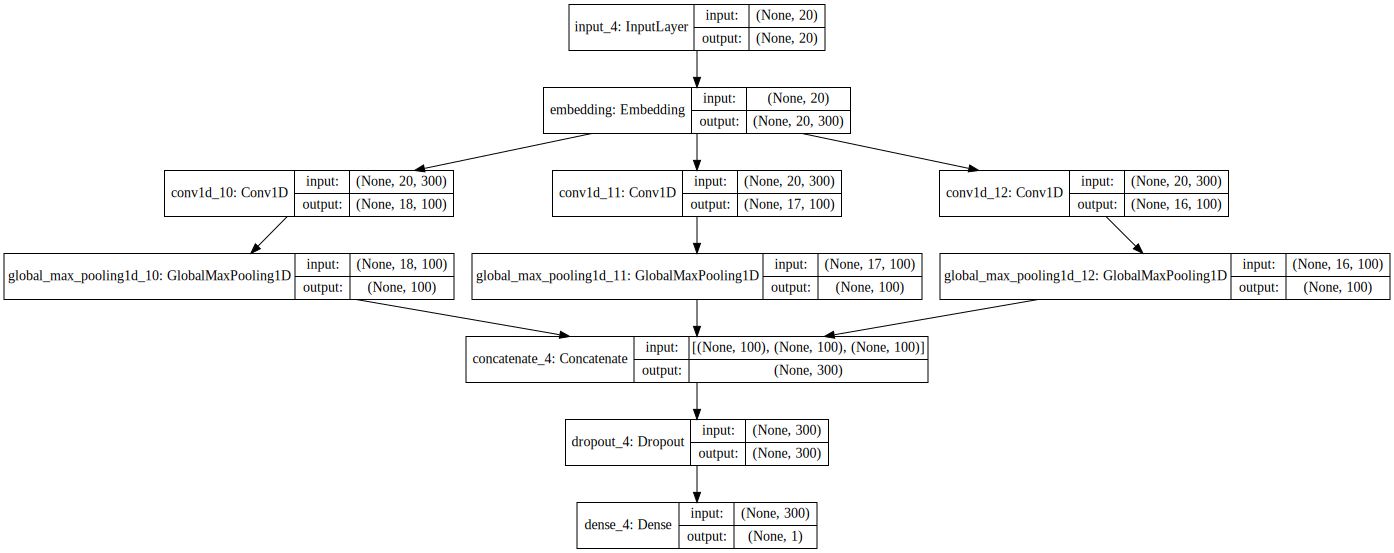

In [92]:
model_rand.summary(85)
SVG(model_to_dot(model_rand, show_shapes=True).create(prog='dot', format='svg'))

Now we are ready to train the model:

In [29]:
num_epochs = 10
history_rand = model_rand.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 1500 samples, validate on 10000 samples
Epoch 1/10
1s - loss: 0.6919 - acc: 0.5213 - val_loss: 0.6863 - val_acc: 0.5282
Epoch 2/10
0s - loss: 0.6277 - acc: 0.7900 - val_loss: 0.6702 - val_acc: 0.6077
Epoch 3/10
0s - loss: 0.5417 - acc: 0.8827 - val_loss: 0.6436 - val_acc: 0.6300
Epoch 4/10
0s - loss: 0.4167 - acc: 0.9233 - val_loss: 0.6204 - val_acc: 0.6409
Epoch 5/10
0s - loss: 0.2696 - acc: 0.9567 - val_loss: 0.6393 - val_acc: 0.6410
Epoch 6/10
0s - loss: 0.1482 - acc: 0.9800 - val_loss: 0.7308 - val_acc: 0.6304
Epoch 7/10
0s - loss: 0.0733 - acc: 0.9947 - val_loss: 0.8258 - val_acc: 0.6317
Epoch 8/10
0s - loss: 0.0366 - acc: 1.0000 - val_loss: 0.9274 - val_acc: 0.6326
Epoch 9/10
0s - loss: 0.0204 - acc: 0.9993 - val_loss: 1.0130 - val_acc: 0.6305
Epoch 10/10
0s - loss: 0.0128 - acc: 1.0000 - val_loss: 1.0894 - val_acc: 0.6303


We can visualize the evolution of loss and accuracy for both the training and validation sets:

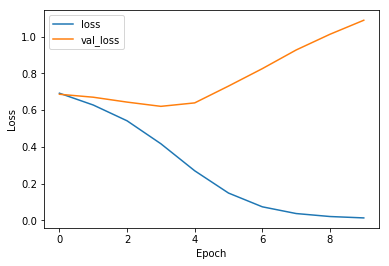

In [30]:
pl.plot(history_rand.history['loss'], label='loss')
pl.plot(history_rand.history['val_loss'], label='val_loss')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Loss')

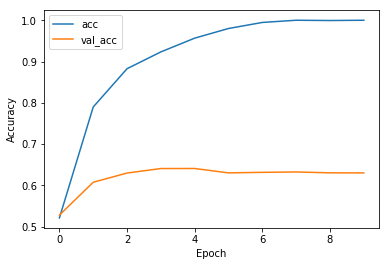

In [31]:
pl.plot(history_rand.history['acc'], label='acc')
pl.plot(history_rand.history['val_acc'], label='val_acc')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Accuracy')

## CNN-static

This model uses word2vec vectors to initialize the embedding. The weights of the embedding are kept fixed so they are not modified by training.

In [32]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer.set_weights([weights])

# Weights is embedding layer are not modified during training
embedding_layer.trainable = False

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(1, activation="sigmoid")(z)

# Model compilation
model_static = Model(model_input, model_output)
model_static.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Initializing embedding layer with word2vec weights, shape (88585, 300)


In [91]:
model_static.summary(85)

_____________________________________________________________________________________
Layer (type)                Output Shape      Param #   Connected to                 
input_5 (InputLayer)        (None, 20)        0                                      
_____________________________________________________________________________________
embedding (Embedding)       (None, 20, 300)   26575500  input_5[0][0]                
_____________________________________________________________________________________
conv1d_13 (Conv1D)          (None, 18, 100)   90100     embedding[0][0]              
_____________________________________________________________________________________
conv1d_14 (Conv1D)          (None, 17, 100)   120100    embedding[0][0]              
_____________________________________________________________________________________
conv1d_15 (Conv1D)          (None, 16, 100)   150100    embedding[0][0]              
______________________________________________________

In [34]:
num_epochs = 10
history_static = model_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 1500 samples, validate on 10000 samples
Epoch 1/10
0s - loss: 0.7075 - acc: 0.5180 - val_loss: 0.6629 - val_acc: 0.5909
Epoch 2/10
0s - loss: 0.5845 - acc: 0.7027 - val_loss: 0.6341 - val_acc: 0.6471
Epoch 3/10
0s - loss: 0.5109 - acc: 0.7887 - val_loss: 0.6178 - val_acc: 0.6627
Epoch 4/10
0s - loss: 0.4470 - acc: 0.8493 - val_loss: 0.6051 - val_acc: 0.6662
Epoch 5/10
0s - loss: 0.3841 - acc: 0.8960 - val_loss: 0.5984 - val_acc: 0.6709
Epoch 6/10
0s - loss: 0.3311 - acc: 0.9113 - val_loss: 0.5966 - val_acc: 0.6750
Epoch 7/10
0s - loss: 0.2816 - acc: 0.9447 - val_loss: 0.5945 - val_acc: 0.6734
Epoch 8/10
0s - loss: 0.2394 - acc: 0.9573 - val_loss: 0.6275 - val_acc: 0.6605
Epoch 9/10
0s - loss: 0.2057 - acc: 0.9627 - val_loss: 0.5952 - val_acc: 0.6805
Epoch 10/10
0s - loss: 0.1681 - acc: 0.9833 - val_loss: 0.5995 - val_acc: 0.6793


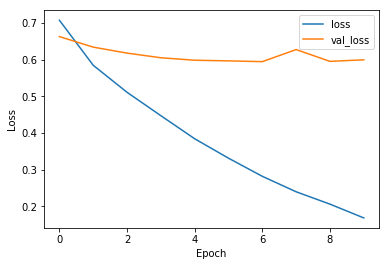

In [35]:
pl.plot(history_static.history['loss'], label='loss')
pl.plot(history_static.history['val_loss'], label='val_loss')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Loss')

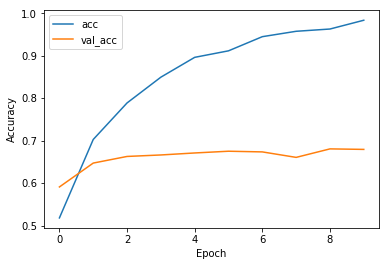

In [36]:
pl.plot(history_static.history['acc'], label='acc')
pl.plot(history_static.history['val_acc'], label='val_acc')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Accuracy')

## CNN-non-static

This model is same as the previous one, but the embedding weights are allowed to change during training.

In [44]:
# Input layer
input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

# Embedding layer
embedding_layer = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")
z = embedding_layer(model_input)
weights = np.array([embedding_weights[i] for i in range(len(embedding_weights))])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer.set_weights([weights])

# Weights is embedding layer are not modified during training
embedding_layer.trainable = True

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

# Dropout 
z = Dropout(dropout_prob[1])(z)

# Output layer
model_output = Dense(1, activation="sigmoid")(z)

# Model compilation
model_non_static = Model(model_input, model_output)
model_non_static.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Initializing embedding layer with word2vec weights, shape (88585, 300)


In [45]:
num_epochs = 10
history_non_static = model_non_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Train on 1500 samples, validate on 10000 samples
Epoch 1/10
1s - loss: 0.7058 - acc: 0.5387 - val_loss: 0.6562 - val_acc: 0.6048
Epoch 2/10
0s - loss: 0.5617 - acc: 0.7287 - val_loss: 0.6333 - val_acc: 0.6384
Epoch 3/10
0s - loss: 0.4491 - acc: 0.8467 - val_loss: 0.6081 - val_acc: 0.6683
Epoch 4/10
0s - loss: 0.3504 - acc: 0.9160 - val_loss: 0.5934 - val_acc: 0.6735
Epoch 5/10
0s - loss: 0.2751 - acc: 0.9387 - val_loss: 0.5934 - val_acc: 0.6772
Epoch 6/10
0s - loss: 0.1946 - acc: 0.9740 - val_loss: 0.5981 - val_acc: 0.6817
Epoch 7/10
0s - loss: 0.1379 - acc: 0.9880 - val_loss: 0.6125 - val_acc: 0.6802
Epoch 8/10
0s - loss: 0.0947 - acc: 0.9953 - val_loss: 0.6370 - val_acc: 0.6794
Epoch 9/10
0s - loss: 0.0648 - acc: 0.9973 - val_loss: 0.6596 - val_acc: 0.6796
Epoch 10/10
0s - loss: 0.0454 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.6775


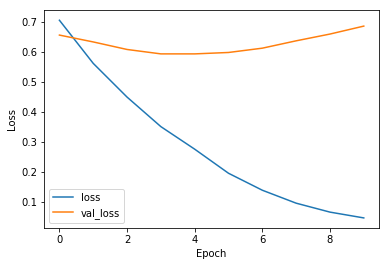

In [46]:
pl.plot(history_non_static.history['loss'], label='loss')
pl.plot(history_non_static.history['val_loss'], label='val_loss')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Loss')

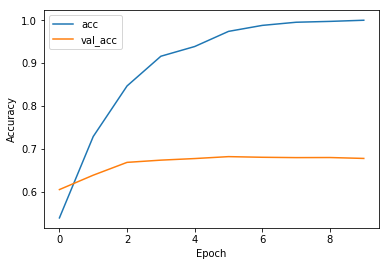

In [47]:
pl.plot(history_non_static.history['acc'], label='acc')
pl.plot(history_non_static.history['val_acc'], label='val_acc')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Accuracy')

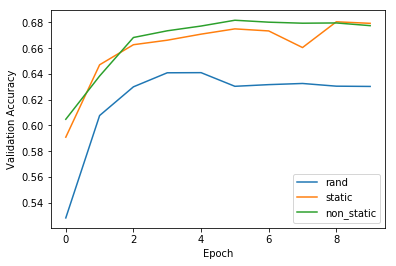

In [48]:
pl.plot(history_rand.history['val_acc'], label='rand')
pl.plot(history_static.history['val_acc'], label='static')
pl.plot(history_non_static.history['val_acc'], label='non_static')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Validation Accuracy')

The word2vec initialization gives a boost of around 4%. Allowing the embedding to fine tune has a small advantage.
## Increasing the data

Now, we will increase the amount of data for training to 25000 samples.

In [55]:
from keras import backend as K

def re_initialize(model):
    session = K.get_session()
    for layer in model.layers: 
         for v in layer.__dict__:
             v_arg = getattr(layer,v)
             if hasattr(v_arg,'initializer'):
                 initializer_method = getattr(v_arg, 'initializer')
                 initializer_method.run(session=session)
                 print('reinitializing layer {}.{}'.format(layer.name, v))

In [80]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None,
                                                      oov_char=None, index_from=None)

x_test = x_test[:10000]
y_test = y_test[:10000]

x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))


x_train shape: (25000, 20)
x_test shape: (10000, 20)
Vocabulary Size: 88585


In [81]:
num_epochs = 10
re_initialize(model_rand)
history_rand = model_rand.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

reinitializing layer embedding.embeddings
reinitializing layer conv1d_10.kernel
reinitializing layer conv1d_10.bias
reinitializing layer conv1d_11.kernel
reinitializing layer conv1d_11.bias
reinitializing layer conv1d_12.kernel
reinitializing layer conv1d_12.bias
reinitializing layer dense_4.kernel
reinitializing layer dense_4.bias
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
9s - loss: 0.5922 - acc: 0.6718 - val_loss: 0.5522 - val_acc: 0.7090
Epoch 2/10
9s - loss: 0.4575 - acc: 0.7826 - val_loss: 0.5571 - val_acc: 0.7138
Epoch 3/10
9s - loss: 0.3560 - acc: 0.8454 - val_loss: 0.6001 - val_acc: 0.7045
Epoch 4/10
9s - loss: 0.2477 - acc: 0.9035 - val_loss: 0.7073 - val_acc: 0.6947
Epoch 5/10
9s - loss: 0.1559 - acc: 0.9454 - val_loss: 0.8489 - val_acc: 0.6884
Epoch 6/10
9s - loss: 0.0935 - acc: 0.9699 - val_loss: 1.0158 - val_acc: 0.6878
Epoch 7/10
9s - loss: 0.0580 - acc: 0.9831 - val_loss: 1.1562 - val_acc: 0.6860
Epoch 8/10
9s - loss: 0.0473 - acc: 0.9857 - val_loss: 1

In [82]:
num_epochs = 10
re_initialize(model_static)
embedding_layer = model_static.get_layer("embedding")
embedding_layer.set_weights([weights])
history_static = model_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

reinitializing layer embedding.embeddings
reinitializing layer conv1d_13.kernel
reinitializing layer conv1d_13.bias
reinitializing layer conv1d_14.kernel
reinitializing layer conv1d_14.bias
reinitializing layer conv1d_15.kernel
reinitializing layer conv1d_15.bias
reinitializing layer dense_5.kernel
reinitializing layer dense_5.bias
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
2s - loss: 0.6050 - acc: 0.6602 - val_loss: 0.5638 - val_acc: 0.6950
Epoch 2/10
3s - loss: 0.5387 - acc: 0.7232 - val_loss: 0.5649 - val_acc: 0.6935
Epoch 3/10
2s - loss: 0.5028 - acc: 0.7524 - val_loss: 0.5556 - val_acc: 0.7017
Epoch 4/10
3s - loss: 0.4679 - acc: 0.7744 - val_loss: 0.5451 - val_acc: 0.7130
Epoch 5/10
2s - loss: 0.4254 - acc: 0.8063 - val_loss: 0.5491 - val_acc: 0.7127
Epoch 6/10
2s - loss: 0.3840 - acc: 0.8294 - val_loss: 0.5583 - val_acc: 0.7101
Epoch 7/10
3s - loss: 0.3468 - acc: 0.8520 - val_loss: 0.5620 - val_acc: 0.7141
Epoch 8/10
2s - loss: 0.3026 - acc: 0.8733 - val_loss: 0

In [83]:
num_epochs = 10
re_initialize(model_non_static)
embedding_layer = model_non_static.get_layer("embedding")
embedding_layer.set_weights([weights])
history_non_static = model_non_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

reinitializing layer embedding.embeddings
reinitializing layer conv1d_19.kernel
reinitializing layer conv1d_19.bias
reinitializing layer conv1d_20.kernel
reinitializing layer conv1d_20.bias
reinitializing layer conv1d_21.kernel
reinitializing layer conv1d_21.bias
reinitializing layer dense_7.kernel
reinitializing layer dense_7.bias
Train on 25000 samples, validate on 10000 samples
Epoch 1/10
9s - loss: 0.5840 - acc: 0.6838 - val_loss: 0.5348 - val_acc: 0.7199
Epoch 2/10
9s - loss: 0.4579 - acc: 0.7804 - val_loss: 0.5504 - val_acc: 0.7157
Epoch 3/10
9s - loss: 0.3773 - acc: 0.8319 - val_loss: 0.5967 - val_acc: 0.7019
Epoch 4/10
9s - loss: 0.2893 - acc: 0.8798 - val_loss: 0.6774 - val_acc: 0.6971
Epoch 5/10
9s - loss: 0.2064 - acc: 0.9221 - val_loss: 0.7492 - val_acc: 0.6970
Epoch 6/10
9s - loss: 0.1393 - acc: 0.9510 - val_loss: 0.8601 - val_acc: 0.6905
Epoch 7/10
9s - loss: 0.0991 - acc: 0.9673 - val_loss: 0.9621 - val_acc: 0.6952
Epoch 8/10
9s - loss: 0.0746 - acc: 0.9753 - val_loss: 1

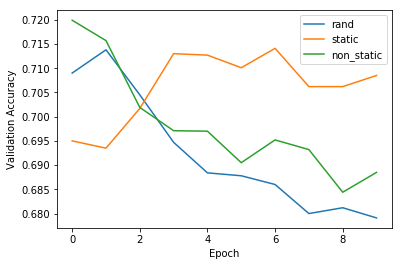

In [84]:
pl.plot(history_rand.history['val_acc'], label='rand')
pl.plot(history_static.history['val_acc'], label='static')
pl.plot(history_non_static.history['val_acc'], label='non_static')
pl.legend()
pl.xlabel('Epoch')
pl.ylabel('Validation Accuracy')

The rand and non_static models overfit. There is not a clear advantage on using word2vec vectors to initialize weights.